In [1611]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

# EDA - разведочный анализ данных
- Изучаем целевую переменную
- Исправление выбросов
- Обработка пропусков
- Приведение типов
- Новые фичи

In [1612]:
TRAIN_DATASET_PATH = 'file:///home/vika/GB/data_libr/Data_kursach/gb-credit-default/train.csv'
TEST_DATASET_PATH = 'file:///home/vika/GB/data_libr/Data_kursach/gb-credit-default/test.csv'

In [1613]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [1614]:
train_df_prep = pd.read_csv(TRAIN_DATASET_PATH)
test_df_prep = pd.read_csv(TEST_DATASET_PATH)

In [1615]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


###### Data fields
- Home Ownership - домовладение <br>
- Annual Income - годовой доход<br>
- Years in current job - количество лет на текущем месте работы<br>
- Tax Liens - налоговые обременения<br>
- Number of Open Accounts - количество открытых счетов<br>
- Years of Credit History - количество лет кредитной истории<br>
- Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)<br>
- Number of Credit Problems - количество проблем с кредитом<br>
- Months since last delinquent - количество месяцев с последней просрочки платежа<br>
- Bankruptcies - банкротства<br>
- Purpose - цель кредита<br>
- Term - срок кредита<br>
- Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)<br>
- Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)<br>
- Monthly Debt - ежемесячный долг<br>
- Credit Score - баллы кредитного рейтинга<br>
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Совпадает ли количество признаков без последней, целевой переменной в тесте и в трейне:

In [1616]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [1617]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## Изучаем целевую переменную

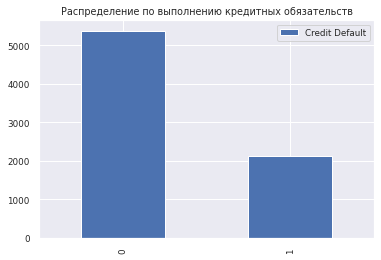

In [1618]:
fig, ax = plt.subplots()    

train_df['Credit Default'].value_counts().plot(kind='bar')

plt.legend()
plt.title('Распределение по выполнению кредитных обязательств');

Как видим, большинство погасило кредит вовремя

## Выбросы

In [1619]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Возможно, есть выбросы у Maximum Open Credit, Current Loan Amount, Credit Score, т.к. есть существенные различия среднего и медианы

#### Исправим выбросы Credit Score

In [1620]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [1621]:
# Credit_score_max_value = np.nanpercentile(train_df['Credit Score'], 80)
Credit_score_max_value = 800

Credit_score_max_value

800

In [1622]:
condition = (train_df['Credit Score'] > Credit_score_max_value)

In [1623]:
train_df.loc[condition, 'Credit Score'] = train_df['Credit Score'].median()
train_df['Credit Score'].describe()

count    5943.000000
mean      721.398788
std        26.828497
min       585.000000
25%       711.000000
50%       731.000000
75%       740.000000
max       751.000000
Name: Credit Score, dtype: float64

#### Исправим выбросы Current Loan Amount

In [1624]:
train_df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [1625]:
Current_Loan_Amount_max_value = np.nanpercentile(train_df['Current Loan Amount'], 70)
Current_Loan_Amount_max_value

446952.0

In [1626]:
# condition = (train_df['Current Loan Amount'] > Current_Loan_Amount_max_value)

# train_df.loc[condition, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()
# train_df['Current Loan Amount'].describe()

#### Исправим выбросы Maximum Open Credit

In [1627]:
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [1628]:
condition = (train_df['Maximum Open Credit'] > 60000000)

train_df.loc[condition, 'Maximum Open Credit']

44      3.800523e+08
617     1.304726e+09
2617    2.655129e+08
Name: Maximum Open Credit, dtype: float64

In [1629]:
train_df.loc[condition, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     6.853061e+05
std      1.263483e+06
min      0.000000e+00
25%      2.792295e+05
50%      4.781535e+05
75%      7.931660e+05
max      5.756256e+07
Name: Maximum Open Credit, dtype: float64

#### Годовой доход - Annual Incom

In [1630]:
train_df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [1631]:
Annual_Income_max_value = np.nanpercentile(train_df['Annual Income'], 75)
Annual_Income_max_value

1640137.0

In [1632]:
Annual_Income_min_value = np.nanpercentile(train_df['Annual Income'], 2.5)
Annual_Income_min_value

447499.4

In [1633]:
# condition = (train_df['Annual Income'] > Annual_Income_max_value) | (train_df['Annual Income'] < Annual_Income_min_value)


# train_df.loc[condition, 'Annual Income'] = train_df['Annual Income'].median()
# train_df['Annual Income'].describe()

## Обработка пропусков

In [1634]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Годовой доход - Annual Incom

In [1635]:
train_df['Annual Income'].isna().sum()

1557

Indicator Method - новый признак, предупреждающий о пропуске в этом объекте

In [1636]:
train_df['Annual_Income_nan'] = 0
train_df.loc[train_df['Years in current job'].isna(), 'Annual_Income_nan'] = 1

In [1637]:
mean = train_df['Annual Income'].mean()

In [1638]:
train_df['Annual Income'].fillna(mean, inplace=True)

In [1639]:
train_df['Annual Income'].isna().sum()

0

### Количество лет на текущем месте работы - Years in current job

In [1640]:
train_df['Years in current job'].isna().sum()

371

In [1641]:
train_df['Years_in_current_job_nan'] = 0
train_df.loc[train_df['Years in current job'].isna(), 'Years_in_current_job_nan'] = 1

In [1642]:
mode = train_df['Years in current job'].mode()[0]
train_df['Years in current job'].fillna(mode, inplace=True)

In [1643]:
train_df['Years in current job'].isna().sum()

0

###  Количество месяцев с последней просрочки платежа - Months since last delinquent

In [1644]:
train_df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [1645]:
train_df['Months since last delinquent'].isna().sum()

4081

In [1646]:
train_df['Months_since_last_delinquent_nan'] = 0
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months_since_last_delinquent_nan'] = 1

In [1647]:
pd.DataFrame(train_df.groupby('Number of Credit Problems').sum()\
            ['Months_since_last_delinquent_nan']).\
            rename(columns={'Months_since_last_delinquent_nan': 'Количество пропусков в Months since last delinquent'})

,Количество пропусков в Months since last delinquent
Number of Credit Problems,
0.0,3557
1.0,468
2.0,38
3.0,15
4.0,3
5.0,0
6.0,0
7.0,0


In [1648]:
# train_df.groupby('Number of Open Accounts').agg({'Months_since_last_delinquent_nan': 'count'}).rename(columns={'Number of Credit Problems': 'sum'}).rename(columns={'Months_since_last_delinquent_nan': 'Количество пропусков в Months since last delinquent'})

Видим, что из 4081 пропусков среди переменной количество месяцев с последней просрочки платежа, 3557 - те, кто не имеет кредитных проблем. 468 - те, у кого 1 проблема. Такой же зависимости среди переменной Number of Open Accounts не обнаруживается. <br>
Тогда заполню те пропуски, где количество кредитных проблем = 0, 0. А остальные медианой среди тех, чьи кредитные проблемы = 1. 

In [1649]:
condition_zero = (train_df['Months since last delinquent'].isna()) & (train_df['Number of Credit Problems'] == 0)

train_df.loc[condition_zero, 'Months since last delinquent'] = 0

In [1650]:
condition_rest = train_df['Months since last delinquent'].isna()

mean = train_df['Months since last delinquent'].mean()

train_df.loc[condition_rest, 'Months since last delinquent'] = mean

In [1651]:
train_df['Months since last delinquent'].isna().sum()

0

### Банкротства - Bankruptcies

In [1652]:
train_df['Bankruptcies'].isna().sum()

14

Заполним пропуски модой - 0

In [1653]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [1654]:
train_df['Bankruptcies_nan'] = 0
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1

In [1655]:
mode = train_df['Bankruptcies'].mode()[0]
train_df['Bankruptcies'].fillna(mode, inplace=True)

In [1656]:
train_df['Bankruptcies'].isna().sum()

0

###  Баллы кредитного рейтинга - Credit Score

In [1657]:
train_df['Credit Score'].isna().sum()

1557

Заполняем пропуски медианой

In [1658]:
train_df['Credit Score'].describe()

count    5943.000000
mean      721.398788
std        26.828497
min       585.000000
25%       711.000000
50%       731.000000
75%       740.000000
max       751.000000
Name: Credit Score, dtype: float64

In [1659]:
train_df['Credit_Score_nan'] = 0
train_df.loc[train_df['Credit Score'].isna(), 'Credit_Score_nan'] = 1

In [1660]:
median = train_df['Credit Score'].median()
train_df['Credit Score'].fillna(median, inplace=True)

In [1661]:
train_df['Credit Score'].isna().sum()

0

## Приведение типов данных

### Количество лет на текущем месте работы - Years in current job

In [1662]:
train_df['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Я бы перевела этот признак в количественный

In [1663]:
years_job_dictionary = {'10+ years': 10, '2 years' : 2, '3 years' : 3, '< 1 year' : 0.5, 
                        '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6,
                        '7 years': 7, '8 years': 8, '9 years': 9, np.nan : 0}

In [1664]:
train_df['Years in current job'] = train_df['Years in current job'].apply(lambda x: years_job_dictionary[x])

In [1665]:
train_df['Years in current job'].value_counts()

10.0    2703
2.0      705
3.0      620
0.5      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64

### Term

In [1666]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [1667]:
term_dictionary = {'Short Term': 0, 'Long Term': 1}

In [1668]:
train_df['Term'] = train_df['Term'].apply(lambda x: term_dictionary[x])
test_df['Term'] = test_df['Term'].apply(lambda x: term_dictionary[x])

In [1669]:
train_df['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

## Новые фичи

### Домовладение - Home Ownership

In [1670]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Кажется, Have Mortgage то же, что и Home Mortgage. Объединим эти данные:

In [1671]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

**Используем дамми переменные для генерации новых фич**

In [1672]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,Annual_Income_nan,Years_in_current_job_nan,Months_since_last_delinquent_nan,Bankruptcies_nan,Credit_Score_nan,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,10.0,0.0,11.0,26.3,685960.0,1.0,17.003154,1.0,...,749.0,0,1,1,1,0,0,0,1,0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,0.000000,0.0,...,737.0,1,0,0,1,0,0,0,1,0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,0.000000,0.0,...,742.0,0,0,0,1,0,0,1,0,0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,17.003154,1.0,...,694.0,0,0,0,1,0,0,0,1,0
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,17.003154,0.0,...,719.0,0,0,0,1,0,0,0,0,1


### Срок кредита - Term

In [1673]:
train_df['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

Не факт, что короткий срок лучше длинного, поэтому в бинарный признак я бы не стала переводить. Возможно, эта переменная связана с суммой кредита...

In [1674]:
df_cat = train_df.groupby('Term', as_index=False).median()[['Term', 'Current Loan Amount']]
df_cat = pd.DataFrame(df_cat)
df_cat.rename(columns={'Current Loan Amount': 'median_loan_amount'}, inplace=True)
df_cat.sort_values(by='median_loan_amount')

df_cat

,Term,median_loan_amount
0,0,250118.0
1,1,437063.0


In [1675]:
train_df = train_df.merge(df_cat, on=['Term'])

train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,Annual_Income_nan,Years_in_current_job_nan,Months_since_last_delinquent_nan,Bankruptcies_nan,Credit_Score_nan,Home Mortgage,Own Home,Rent,median_loan_amount
0,Own Home,482087.0,10.0,0.0,11.0,26.3,685960.0,1.0,17.003154,1.0,...,0,1,1,1,0,0,0,1,0,250118.0
1,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,0.000000,0.0,...,0,0,0,1,0,0,1,0,0,250118.0
2,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,17.003154,1.0,...,0,0,0,1,0,0,0,1,0,250118.0
3,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,17.003154,0.0,...,0,0,0,1,0,0,0,0,1,250118.0
4,Home Mortgage,1511108.0,10.0,0.0,9.0,20.3,388124.0,0.0,73.000000,0.0,...,0,0,0,0,0,0,1,0,0,250118.0


### Годовой доход - Annual Incom

Разобъём на категории этот признак. Типа бедные (1), средний класс (2) и богатые (3).

In [1676]:
bin_labels_3 = ['1', '2', '3']

train_df['annual_income_cat'] = pd.qcut(train_df['Annual Income'], q = 3, labels=bin_labels_3)

In [1677]:
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Annual_Income_nan,Years_in_current_job_nan,Months_since_last_delinquent_nan,Bankruptcies_nan,Credit_Score_nan,Home Mortgage,Own Home,Rent,median_loan_amount,annual_income_cat
0,Own Home,482087.0,10.0,0.0,11.0,26.3,685960.0,1.0,17.003154,1.0,...,1,1,1,0,0,0,1,0,250118.0,1
1,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,0.000000,0.0,...,0,0,1,0,0,1,0,0,250118.0,1
2,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,17.003154,1.0,...,0,0,1,0,0,0,1,0,250118.0,1
3,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,17.003154,0.0,...,0,0,1,0,0,0,0,1,250118.0,1
4,Home Mortgage,1511108.0,10.0,0.0,9.0,20.3,388124.0,0.0,73.000000,0.0,...,0,0,0,0,0,1,0,0,250118.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Own Home,743432.0,5.0,0.0,11.0,18.9,763642.0,0.0,45.000000,0.0,...,0,0,0,0,0,0,1,0,437063.0,1
7496,Rent,567435.0,8.0,0.0,11.0,17.1,365750.0,0.0,8.000000,0.0,...,0,0,0,0,0,0,0,1,437063.0,1
7497,Home Mortgage,1542952.0,10.0,0.0,7.0,12.5,232364.0,0.0,59.000000,0.0,...,0,0,0,0,0,1,0,0,437063.0,3
7498,Rent,1257610.0,8.0,0.0,14.0,16.5,821480.0,0.0,58.000000,0.0,...,0,0,0,0,0,0,0,1,437063.0,2


### Цель кредита - Purpose

In [1678]:
# train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'])], axis=1)
# train_df.head()

# Смотрим на тест

## Выбросы

**Credit Score**

In [1679]:
Credit_score_max_value = 800

condition = (test_df['Credit Score'] > Credit_score_max_value)

test_df.loc[condition, 'Credit Score'] = test_df['Credit Score'].median()
test_df['Credit Score'].describe()

count    1987.000000
mean      721.185204
std        26.435902
min       585.000000
25%       710.000000
50%       731.000000
75%       740.000000
max       751.000000
Name: Credit Score, dtype: float64

**Maximum Open Credit**

In [1680]:
condition = (test_df['Maximum Open Credit'] > 60000000)

test_df.loc[condition, 'Maximum Open Credit']

test_df.loc[condition, 'Maximum Open Credit'] = test_df['Maximum Open Credit'].median()
test_df['Maximum Open Credit'].describe()

count    2.500000e+03
mean     7.105704e+05
std      1.511983e+06
min      0.000000e+00
25%      2.785860e+05
50%      4.786760e+05
75%      8.025985e+05
max      5.448439e+07
Name: Maximum Open Credit, dtype: float64

## Пропуски

In [1681]:
test_df.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [1682]:
test_df['Annual Income'].isna().sum()

513

In [1683]:
test_df['Annual_Income_nan'] = 0
test_df.loc[test_df['Years in current job'].isna(), 'Annual_Income_nan'] = 1

mean = test_df['Annual Income'].mean()

test_df['Annual Income'].fillna(mean, inplace=True)

test_df['Annual Income'].isna().sum()

0

In [1684]:
test_df['Years in current job'].isna().sum()

86

In [1685]:
test_df['Years_in_current_job_nan'] = 0
test_df.loc[test_df['Years in current job'].isna(), 'Years_in_current_job_nan'] = 1

mode = test_df['Years in current job'].mode()[0]
test_df['Years in current job'].fillna(mode, inplace=True)

test_df['Years in current job'].isna().sum()

0

In [1686]:
test_df['Months since last delinquent'].isna().sum()

1358

In [1687]:
test_df['Months_since_last_delinquent_nan'] = 0
test_df.loc[test_df['Months since last delinquent'].isna(), 'Months_since_last_delinquent_nan'] = 1

condition_zero = (test_df['Months since last delinquent'].isna()) & (test_df['Number of Credit Problems'] == 0)
test_df.loc[condition_zero, 'Months since last delinquent'] = 0

condition_rest = test_df['Months since last delinquent'].isna()
mean = test_df['Months since last delinquent'].mean()
test_df.loc[condition_rest, 'Months since last delinquent'] = mean

test_df['Months since last delinquent'].isna().sum()

0

In [1688]:
test_df['Credit Score'].isna().sum()

513

In [1689]:
test_df['Credit_Score_nan'] = 0
test_df.loc[test_df['Credit Score'].isna(), 'Credit_Score_nan'] = 1

median = test_df['Credit Score'].median()
test_df['Credit Score'].fillna(median, inplace=True)

test_df['Credit Score'].isna().sum()

0

In [1690]:
test_df['Bankruptcies'].isna().sum()

3

In [1691]:
test_df['Bankruptcies_nan'] = 0
test_df.loc[test_df['Bankruptcies'].isna(), 'Bankruptcies_nan'] = 1

mode = test_df['Bankruptcies'].mean()
test_df['Bankruptcies'].fillna(mode, inplace=True)

test_df['Bankruptcies'].isna().sum()

0

## Новые фичи

In [1692]:
years_job_dictionary = {'10+ years': 10, '2 years' : 2, '3 years' : 3, '< 1 year' : 0.5, 
                        '5 years': 5, '1 year': 1, '4 years': 4, '6 years': 6,
                        '7 years': 7, '8 years': 8, '9 years': 9, np.nan : 0}

test_df['Years in current job'] = test_df['Years in current job'].apply(lambda x: years_job_dictionary[x])

In [1693]:
test_df.loc[test_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

# Выбираем признаки для обучения

Изучим, есть ли корреляция признаков с целевой перменной

In [1694]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

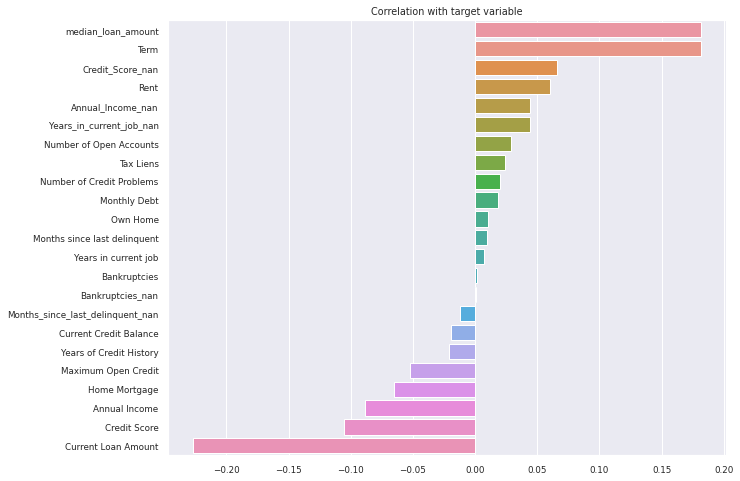

In [1695]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Видим, что Credit Score и Current Loan Amount коррелируют с целевой переменной. Важные для нас признаки!

## Матрица корреляций

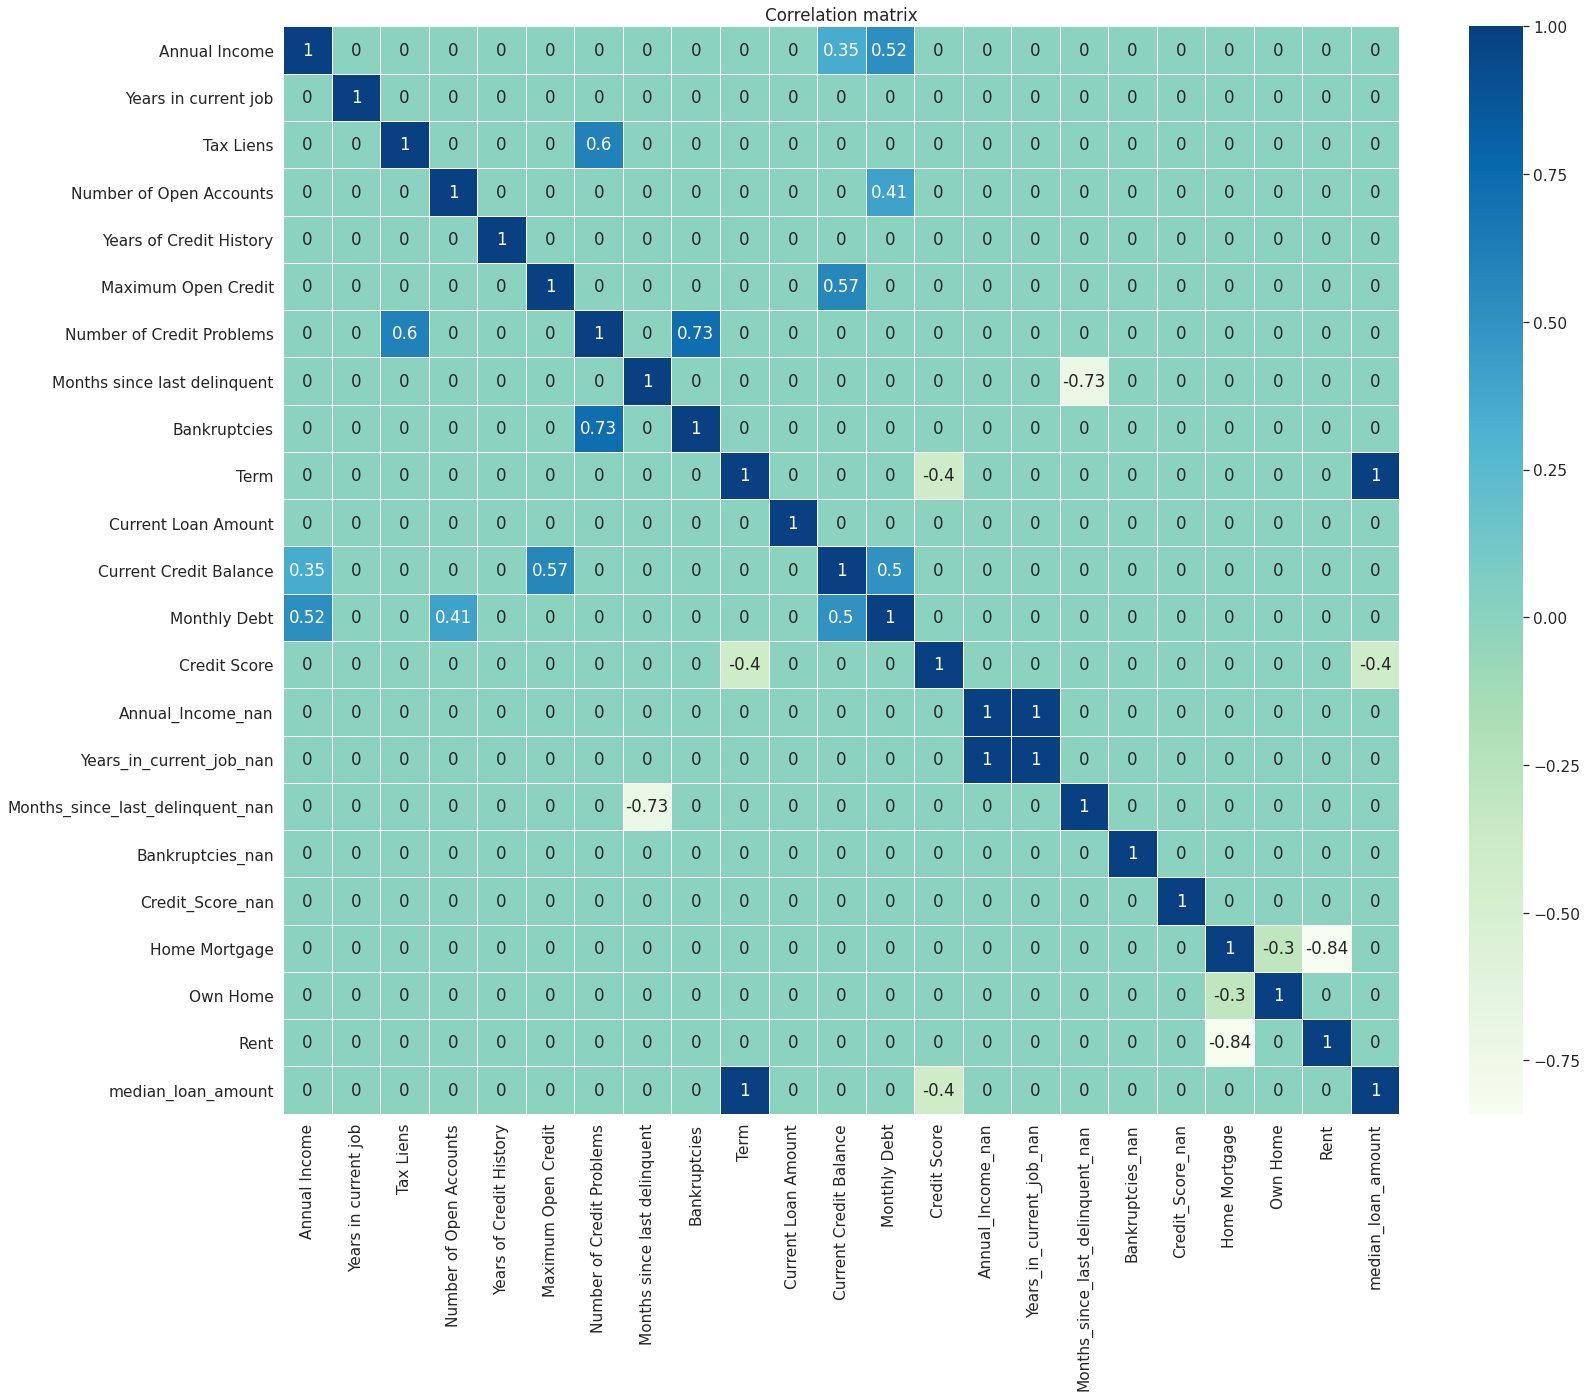

In [1696]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.4)

corr_matrix = train_df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Видим, что некоторые признаки коррелируют друг с другом и их можно объединять друг с другом

**Посмотрим прицельно на признаки и их влияение на целевую переменную**

### Годовой доход - Annual Incom

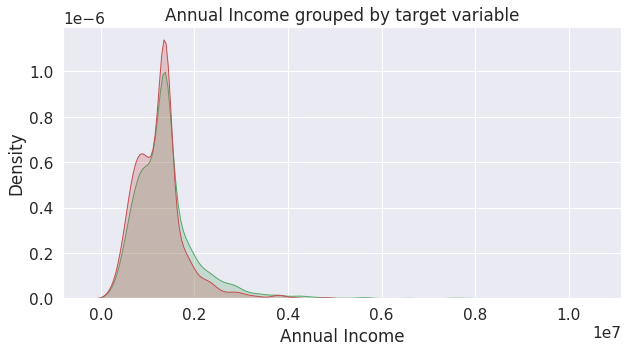

In [1697]:
loan_with_target = train_df[['Annual Income', TARGET_NAME]]
loan_ = loan_with_target['Annual Income']
loan_target_0 = loan_[loan_with_target[TARGET_NAME] == 0]
loan_target_1 = loan_[loan_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(loan_target_0, shade=True, label='', color='g')
sns.kdeplot(loan_target_1, shade=True, label='', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

Видим, что разбияния имеют разные рапспределения относительно целевой переменной, что может означать некоторую зависимость между этим признаком и целевой переменной

###  Текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту) - Current Loan Amount

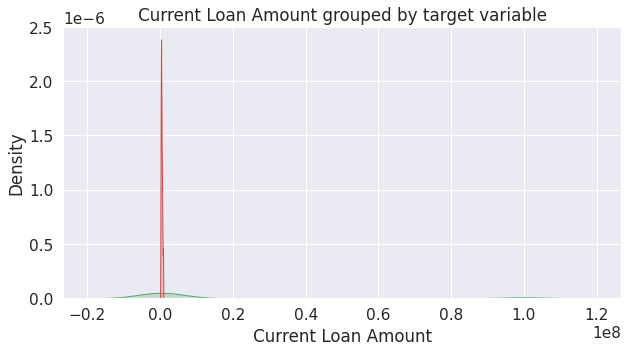

In [1698]:
loan_with_target = train_df[['Current Loan Amount', TARGET_NAME]]
loan_ = loan_with_target['Current Loan Amount']
loan_target_0 = loan_[loan_with_target[TARGET_NAME] == 0]
loan_target_1 = loan_[loan_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(loan_target_0, shade=True, label='', color='g')
sns.kdeplot(loan_target_1, shade=True, label='', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

Видим, что разбияния имеют разные рапсределения относительно целевой переменной, что может означать некоторую зависимость между этим признаком и целевой переменной

###  Баллы кредитного рейтинга - Credit Score

Оценка признака 'Credit Score' в разрезе целевой перменной


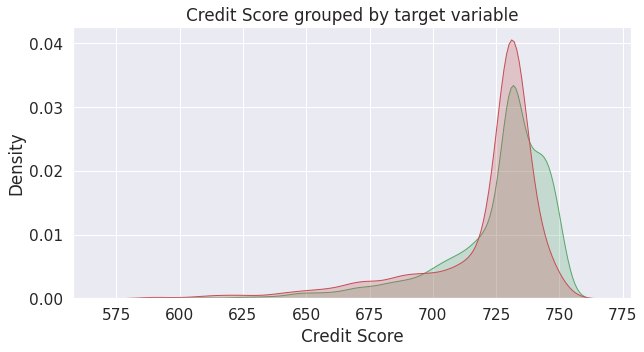

In [1699]:
cred_score_with_target = train_df[['Credit Score', TARGET_NAME]]
cred_score = cred_score_with_target['Credit Score']
cred_score_target_0 = cred_score[cred_score_with_target[TARGET_NAME] == 0]
cred_score_target_1 = cred_score[cred_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cred_score_target_0, shade=True, label='', color='g')
sns.kdeplot(cred_score_target_1, shade=True, label='', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

Видим, что разбияния имеют разные рапсределения относительно целевой переменной, что может означать некоторую зависимость между этим признаком и целевой переменной

**Проверим на нормальность наше распределение значений**

In [1700]:
shapiro(cred_score)

ShapiroResult(statistic=0.7849956750869751, pvalue=0.0)

Распределение не нормальное - применять тест Стюдента не можем

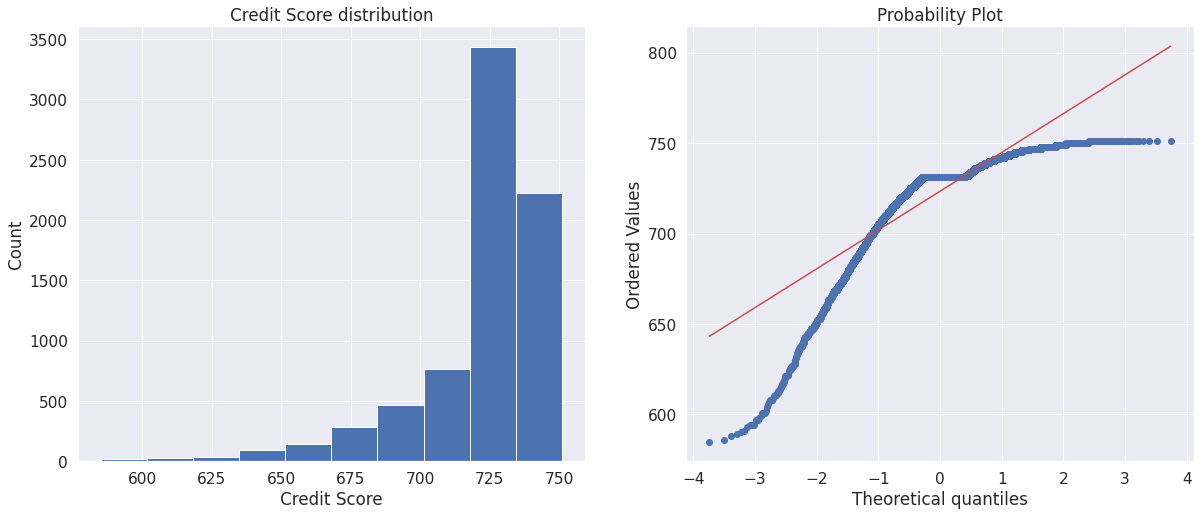

In [1701]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
cred_score.hist()

plt.subplot(122)
probplot(cred_score, dist='norm', plot=plt)

plt.show()

In [1702]:
mannwhitneyu(cred_score_target_0, cred_score_target_1)

MannwhitneyuResult(statistic=4724307.5, pvalue=2.4689678041362667e-31)

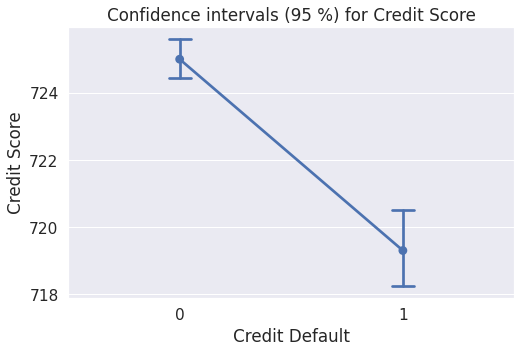

In [1703]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=cred_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Домовладение - Home Ownership

Оценка признака Home Ownership в разрезе целевой перменной

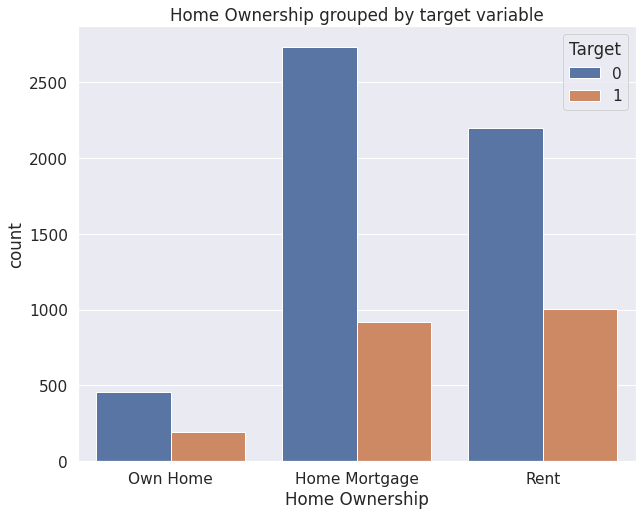

In [1704]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=train_df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Возможно, Home Mortgage и Rent имеют схожие доли в разрезе целевой переменной. Проверим это.

In [1705]:
train_df['Id'] = train_df.index
home_over_and_target_s = train_df.loc[train_df['Home Ownership'].isin(['Rent', 'Home Mortgage']), ['Id', 'Home Ownership', 'Credit Default']]

table = home_over_and_target_s.pivot_table(values='Id', index='Home Ownership', columns='Credit Default', aggfunc='count')

chi2, p, _, _ = chi2_contingency(table)
p

1.845860201996177e-08

p < 0.05, значит мы не можем принять нулевую гипотезу - Home Mortgage и Rent неодинаково влияют на нашу переменную. Значит их нельзя объединять.

In [1706]:
train_df['Id'] = train_df.index
home_over_and_target_s = train_df.loc[train_df['Home Ownership'].isin(['Own Home', 'Home Mortgage']), ['Id', 'Home Ownership', 'Credit Default']]

table = home_over_and_target_s.pivot_table(values='Id', index='Home Ownership', columns='Credit Default', aggfunc='count')

chi2, p, _, _ = chi2_contingency(table)
p

0.017752715719081276

p < 0.05, значит мы не можем принять нулевую гипотезу - Home Mortgage и Own Home неодинаково влияют на нашу переменную. Значит их нельзя объединять.

### Количество лет на текущем месте работы - Years in current job

Оценка признака Home Ownership в разрезе целевой перменной

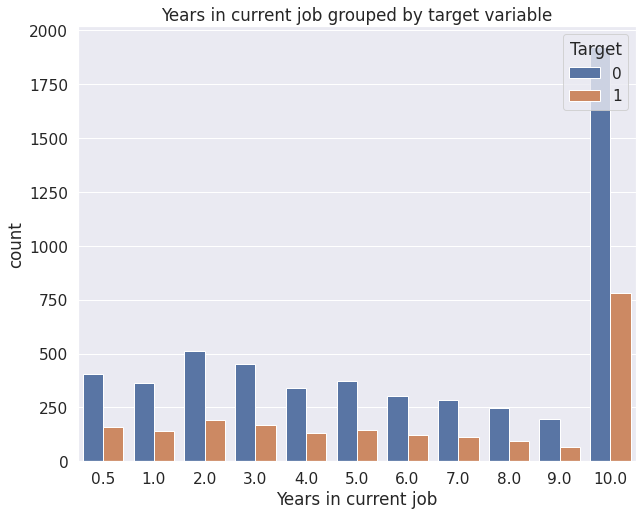

In [1707]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=train_df)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

У нас 10 разных переменных, при этом они выглядят похожими друг на друга. Подсократим-ка!

In [1708]:
def years_in_job_and_target(df):
    df['Id'] = df.index
    
    for i in df['Years in current job'].unique():
        for j in df['Years in current job'].unique():
            _and_target_s = df.loc[df['Years in current job'].isin([i, j]), ['Id', 'Years in current job', 'Credit Default']]

            table = _and_target_s.pivot_table(values='Id', index='Years in current job', columns='Credit Default', aggfunc='count')

            chi2, p, _, _ = chi2_contingency(table)
            
            if p < 0.05:
                print(i, j, p)

years_in_job_and_target(train_df)

Получается, все значения одинаково вияют на нашу целевую переменную

### Цель кредита - Purpose

Оценка признака Purpose в разрезе целевой перменной

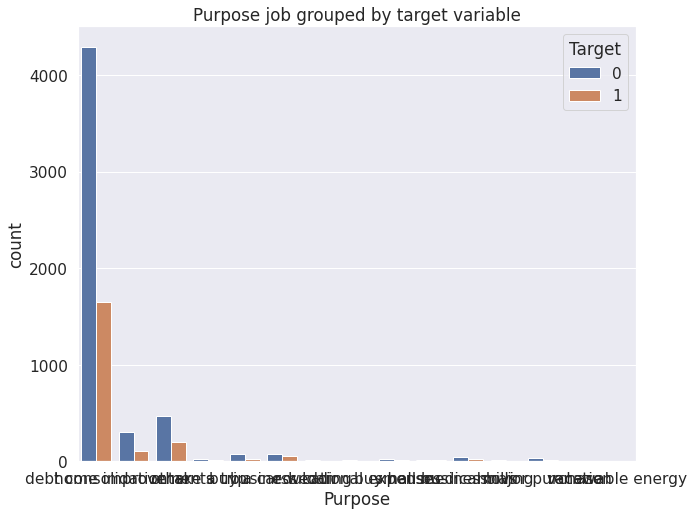

In [1709]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
plt.title('Purpose job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1710]:
def purpose_and_target(df):
    df['Id'] = df.index
    
    for i in df['Purpose'].unique():
        for j in df['Purpose'].unique():
            _and_target_s = df.loc[df['Purpose'].isin([i, j]), ['Id', 'Purpose', 'Credit Default']]

            table = _and_target_s.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')

            chi2, p, _, _ = chi2_contingency(table)
            
            if p > 0.05:
                print(i, j, p)

purpose_and_target(train_df)

debt consolidation debt consolidation 1.0
debt consolidation home improvements 0.5154852485989191
debt consolidation other 0.3505400870952239
debt consolidation take a trip 0.9395508995654579
debt consolidation buy a car 0.6181511506912076
debt consolidation wedding 0.8506055935734426
debt consolidation educational expenses 0.3659823371644395
debt consolidation buy house 0.9872449113508569
debt consolidation medical bills 0.6475542807628238
debt consolidation moving 0.7065614327969658
debt consolidation major purchase 0.5670467296082156
debt consolidation vacation 0.8286186093608676
home improvements debt consolidation 0.5154852485989191
home improvements home improvements 1.0
home improvements other 0.2552281402751723
home improvements take a trip 0.9304537392510556
home improvements buy a car 0.9084708624865527
home improvements wedding 0.7951748091131776
home improvements educational expenses 0.42845295138233785
home improvements buy house 0.8649543540332052
home improvements medica

Выглядит так, что можно объединить почти все значения

### Налоговые обременения - Tax Liens

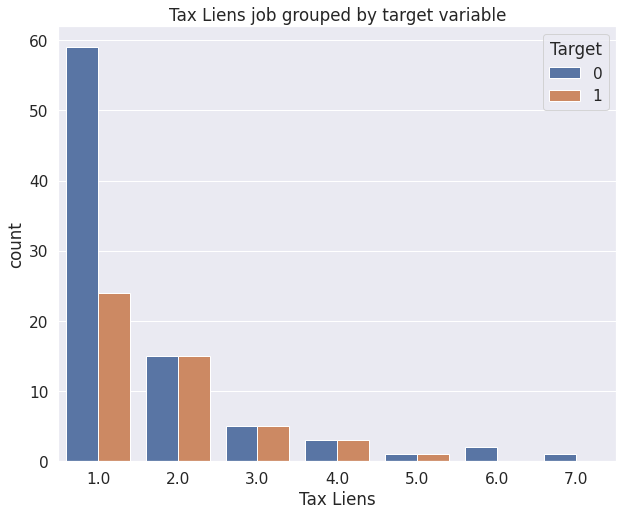

In [1711]:
train_df_Tax = train_df[train_df['Tax Liens'] != 0]

plt.figure(figsize=(10, 8))

sns.countplot(x ='Tax Liens', hue=TARGET_NAME, data=train_df_Tax)
plt.title('Tax Liens job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1712]:
def tax_liens_and_target(df):
    df['Id'] = df.index
    
    for i in df['Tax Liens'].unique():
        for j in df['Tax Liens'].unique():
            _and_target_s = df.loc[df['Tax Liens'].isin([i, j]), ['Id', 'Tax Liens', 'Credit Default']]

            table = _and_target_s.pivot_table(values='Id', index='Tax Liens', columns='Credit Default', aggfunc='count')

            chi2, p, _, _ = chi2_contingency(table)

            if p > 0.05:
                print(i, j, p)

tax_liens_and_target(train_df)

0.0 0.0 1.0
0.0 3.0 0.23295831174186302
0.0 1.0 0.956212700856196
0.0 5.0 0.9237369590696908
0.0 4.0 0.4577135722942197
3.0 0.0 0.23295831174186302
3.0 3.0 1.0
3.0 1.0 0.31807206467542815
3.0 2.0 1.0
3.0 5.0 1.0
3.0 4.0 1.0
1.0 0.0 0.956212700856196
1.0 3.0 0.31807206467542815
1.0 1.0 1.0
1.0 2.0 0.06319619269040552
1.0 5.0 0.8897894882095201
1.0 4.0 0.5318974167537951
2.0 3.0 1.0
2.0 1.0 0.06319619269040552
2.0 2.0 1.0
2.0 5.0 1.0
2.0 4.0 1.0
6.0 6.0 1.0
6.0 7.0 1.0
5.0 0.0 0.9237369590696908
5.0 3.0 1.0
5.0 1.0 0.8897894882095201
5.0 2.0 1.0
5.0 5.0 1.0
5.0 4.0 1.0
4.0 0.0 0.4577135722942197
4.0 3.0 1.0
4.0 1.0 0.5318974167537951
4.0 2.0 1.0
4.0 5.0 1.0
4.0 4.0 1.0
7.0 6.0 1.0
7.0 7.0 1.0


Выглядит так, что почти все значения можно объединить

## Сравниваем тест и трейн

Annual Income
MannwhitneyuResult(statistic=8993119.5, pvalue=0.0011034506309187584)


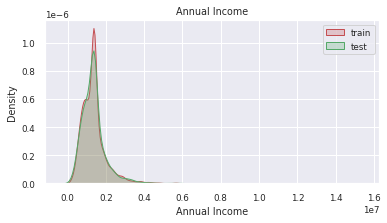

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


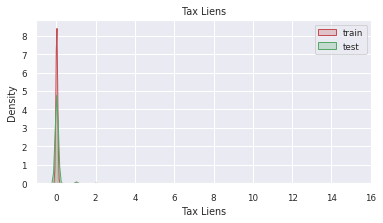

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


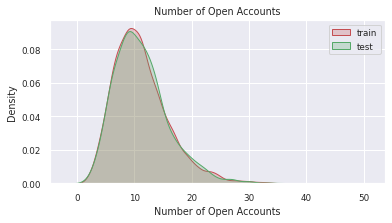

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


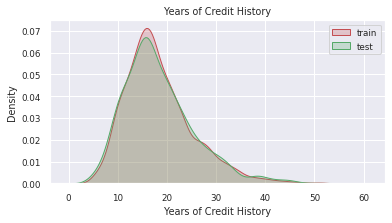

Maximum Open Credit
MannwhitneyuResult(statistic=9334116.0, pvalue=0.37181438010535184)


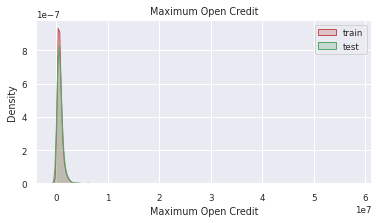

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


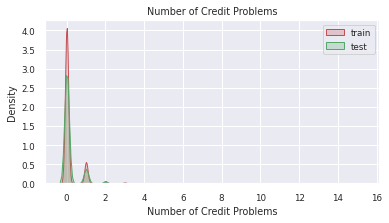

Months since last delinquent
MannwhitneyuResult(statistic=9269863.0, pvalue=0.18648364729334382)


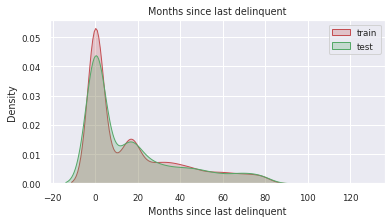

Bankruptcies
MannwhitneyuResult(statistic=9270984.0, pvalue=0.06043830958867015)


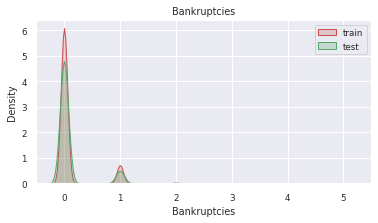

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


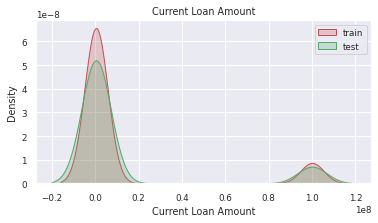

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


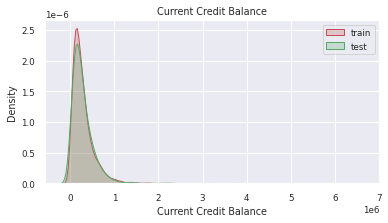

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


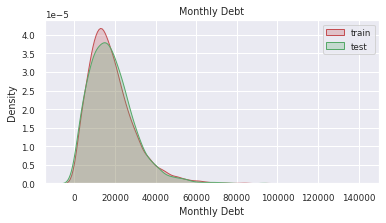

Credit Score
MannwhitneyuResult(statistic=9247418.5, pvalue=0.15114281548880665)


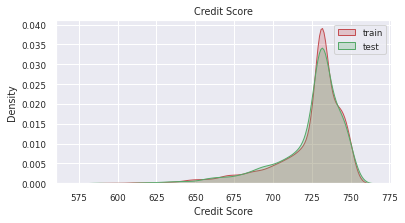

In [1713]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

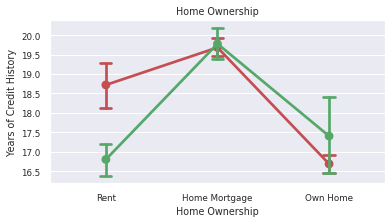

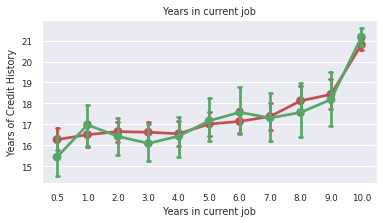

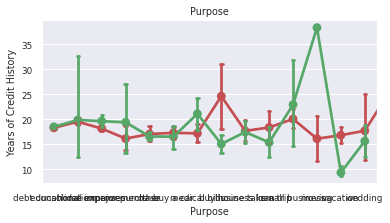

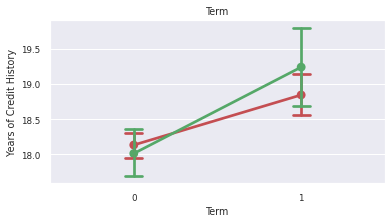

In [1714]:
num_feature = 'Years of Credit History'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

Сократим значения в Home Ownership

In [1715]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [1716]:
def change_pay_1(df):
    df.loc[df['Home Ownership'] == 'Rent', 'Home Ownership'] = 'Home Mortgage'
    return df


test = change_pay_1(test_df)
train = change_pay_1(train_df)

In [1717]:
def change_pay_1(df):
    df.loc[df['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 0
    df.loc[df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 1
    return df


test = change_pay_1(test_df)
train = change_pay_1(train_df)

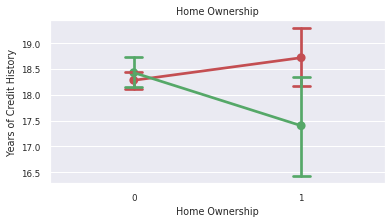

In [1718]:
num_feature = 'Years of Credit History'
col = 'Home Ownership'
plt.figure(figsize=figsize)
sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

Annual Income не берём, Purpose

In [1719]:
del_cols = ['Annual Income', 'Purpose']

train_df.drop(columns=del_cols, inplace=True)
test_df.drop(columns=del_cols, inplace=True)

train_df_prep.drop(columns=del_cols, inplace=True)
test_df_prep.drop(columns=del_cols, inplace=True)

# Обучение

In [1720]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [1721]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1722]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [1723]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [1724]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [1725]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df_prep.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Tax Liens',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Years in current job', 'Home Ownership', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + list(NEW_FEATURE_NAMES)

In [1726]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

In [1727]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[NUM_FEATURE_NAMES])
X_test[NUM_FEATURE_NAMES] = scaler.transform(X_test_norm[NUM_FEATURE_NAMES])

In [1728]:
from pathlib import Path
MODELS_PATH = Path('/home/vika/GB/data_libr/Data_kursach/')

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)
    
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# train_df.to_csv(MODELS_PATH / 'df.csv', index=False, encoding='utf-8')
# train.to_csv(MODELS_PATH / 'train.csv', index=False, encoding='utf-8')
# test.to_csv(MODELS_PATH / 'test.csv', index=False, encoding='utf-8')

## Построение моделей

In [1729]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3771
           1       0.00      0.00      0.00      1479

    accuracy                           0.72      5250
   macro avg       0.36      0.50      0.42      5250
weighted avg       0.52      0.72      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1616
           1       0.00      0.00      0.00       634

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0              0
Credit Default      
0               1616
1                634


In [1730]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3771
           1       0.68      0.40      0.50      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.66      0.68      5250
weighted avg       0.76      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1616
           1       0.36      0.22      0.27       634

    accuracy                           0.67      2250
   macro avg       0.55      0.53      0.53      2250
weighted avg       0.63      0.67      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1370  246
1                495  139


In [1731]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:3.6},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.42      0.57      3771
           1       0.37      0.89      0.53      1479

    accuracy                           0.55      5250
   macro avg       0.64      0.65      0.55      5250
weighted avg       0.75      0.55      0.56      5250

TEST

              precision    recall  f1-score   support

           0       0.89      0.41      0.56      1616
           1       0.36      0.87      0.51       634

    accuracy                           0.54      2250
   macro avg       0.62      0.64      0.53      2250
weighted avg       0.74      0.54      0.54      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               655  961
1                85  549


In [1732]:
train_df['Home Ownership'] = train_df['Home Ownership'].astype(int)
test_df['Home Ownership'] = test_df['Home Ownership'].astype(int)

In [1733]:
train_df = train_df.rename(columns={'Home Mortgage': 'Home M'})
test_df = test_df.rename(columns={'Home Mortgage': 'Home M'})

In [1734]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Home Ownership                    7500 non-null   int64   
 1   Years in current job              7500 non-null   float64 
 2   Tax Liens                         7500 non-null   float64 
 3   Number of Open Accounts           7500 non-null   float64 
 4   Years of Credit History           7500 non-null   float64 
 5   Maximum Open Credit               7500 non-null   float64 
 6   Number of Credit Problems         7500 non-null   float64 
 7   Months since last delinquent      7500 non-null   float64 
 8   Bankruptcies                      7500 non-null   float64 
 9   Term                              7500 non-null   int64   
 10  Current Loan Amount               7500 non-null   float64 
 11  Current Credit Balance            7500 non-null   float6

In [1735]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df_prep.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Tax Liens',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Years in current job', 'Home Ownership', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + list(NEW_FEATURE_NAMES)

In [1736]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

In [1737]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:3.6},
                                 n_estimators=10
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.46      0.62      3771
           1       0.41      0.95      0.57      1479

    accuracy                           0.60      5250
   macro avg       0.68      0.71      0.60      5250
weighted avg       0.80      0.60      0.61      5250

TEST

              precision    recall  f1-score   support

           0       0.89      0.44      0.59      1616
           1       0.38      0.87      0.53       634

    accuracy                           0.56      2250
   macro avg       0.64      0.65      0.56      2250
weighted avg       0.75      0.56      0.57      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               709  907
1                84  550
CPU times: user 1.72 s, sys: 50.4 ms, total: 1.77 s
Wall time: 983 ms


In [1738]:
train_df['Years in current job'] = train_df['Years in current job'].astype(int)
test_df['Years in current job'] = test_df['Years in current job'].astype(int)

In [1739]:
train_df.drop('annual_income_cat', axis=1, inplace=True)

In [1740]:
X = train_df[BASE_FEATURE_NAMES]
y = train_df[TARGET_NAME]

CAT_FEATURE_NAMES = ['Term', 'Home Ownership', 'Years in current job']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [1741]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [1742]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
#                                      early_stopping_rounds=20,
#                                      use_best_model=True,
#                                      custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1743]:
model_catb.best_score_

{'learn': {'Logloss': 0.27010268732070164, 'F1': 0.95683048816875},
 'validation': {'Logloss': 0.5956496953913928, 'F1': 0.694953715049636}}

## Подбор параметров

In [1744]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [1745]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [1746]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [1747]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.725420823
bestIteration = 0

0:	loss: 0.7254208	best: 0.7254208 (0)	total: 286ms	remaining: 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.725420823
bestIteration = 1

1:	loss: 0.7254208	best: 0.7254208 (0)	total: 531ms	remaining: 3.45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.725420823
bestIteration = 1

2:	loss: 0.7254208	best: 0.7254208 (0)	total: 769ms	remaining: 3.08s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.725420823
bestIteration = 1

3:	loss: 0.7254208	best: 0.7254208 (0)	total: 1.03s	remaining: 2.83s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.725420823
bestIteration = 1

4:	loss: 0.7254208	best: 0.7254208 (0)	total: 1.27s	remaining: 2.54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7307958561
bestIteration = 2

5:	loss: 0.7307959	best: 0.7307959 (5)	total: 1.67s	remaining: 2.5s
Stopped

In [1748]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
1,1,0.709303,0.012800,0.706957,0.003631,0.680185,0.000997,0.679874,0.000762
2,2,0.707801,0.010464,0.709644,0.004028,0.674586,0.001210,0.674114,0.000775
18,18,0.706426,0.011998,0.709975,0.005618,0.628008,0.002111,0.624337,0.002679
14,14,0.706377,0.012275,0.710516,0.006029,0.635408,0.002243,0.632294,0.001712
8,8,0.706284,0.012030,0.708403,0.005302,0.652255,0.001962,0.650322,0.002749


In [1749]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.66      0.76      3771
           1       0.48      0.79      0.60      1479

    accuracy                           0.70      5250
   macro avg       0.68      0.73      0.68      5250
weighted avg       0.77      0.70      0.71      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      1616
           1       0.43      0.69      0.53       634

    accuracy                           0.65      2250
   macro avg       0.63      0.66      0.63      2250
weighted avg       0.72      0.65      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1038  578
1                199  435


In [1750]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=7)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.43      0.58      3771
           1       0.37      0.87      0.52      1479

    accuracy                           0.55      5250
   macro avg       0.63      0.65      0.55      5250
weighted avg       0.75      0.55      0.56      5250

TEST

              precision    recall  f1-score   support

           0       0.87      0.42      0.56      1616
           1       0.36      0.84      0.51       634

    accuracy                           0.54      2250
   macro avg       0.62      0.63      0.53      2250
weighted avg       0.73      0.54      0.55      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               672  944
1               100  534
CPU times: user 906 ms, sys: 134 ms, total: 1.04 s
Wall time: 631 ms


In [1751]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df_prep.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Tax Liens',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Years in current job', 'Term', 'Home Mortgage']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + list(NEW_FEATURE_NAMES)

In [1752]:
import inspect

In [1753]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

In [1755]:
stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

[17:37:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.836006,0.836049,0.000000,0.000000,0.418003,0.418025,lr
1,0.782683,0.849479,0.228514,0.473662,0.505598,0.661571,knn
2,0.750544,1.000000,0.373146,1.000000,0.561845,1.000000,tree
3,0.825568,0.972363,0.373469,0.923738,0.599519,0.948050,xgb
4,0.823397,0.928367,0.334746,0.767489,0.579071,0.847928,lgbm
5,0.830880,0.906755,0.322581,0.672680,0.576730,0.789718,cat


In [1756]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [1757]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [1758]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='over')
stata_balanced_over

[17:37:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 27.7 s, sys: 2.95 s, total: 30.7 s
Wall time: 12.3 s


,f1_0_test_over,f1_0_train_over,f1_1_test_over,f1_1_train_over,f1_macro_test_over,f1_macro_train_over,model_name
0,0.736407,0.652379,0.388192,0.447778,0.562299,0.550079,lr
1,0.718391,0.776023,0.355263,0.698291,0.536827,0.737157,knn
2,0.755857,1.000000,0.369427,1.000000,0.562642,1.000000,tree
3,0.786434,0.983200,0.430318,0.978852,0.608376,0.981026,xgb
4,0.792593,0.921861,0.466667,0.898961,0.629630,0.910411,lgbm
5,0.800000,0.905322,0.477108,0.878165,0.638554,0.891743,cat


In [1759]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

0    1479
1    1479
Name: Credit Default, dtype: int64

In [1760]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [1761]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='under')
stata_balanced_under

[17:37:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 21.5 s, sys: 2.15 s, total: 23.6 s
Wall time: 9.22 s


,f1_0_test_under,f1_0_train_under,f1_1_test_under,f1_1_train_under,f1_macro_test_under,f1_macro_train_under,model_name
0,0.479391,0.429637,0.487654,0.675332,0.483523,0.552484,lr
1,0.623982,0.726027,0.434928,0.732977,0.529455,0.729502,knn
2,0.659050,1.000000,0.437905,1.000000,0.548477,1.000000,tree
3,0.672257,0.992874,0.488332,0.992927,0.580295,0.992901,xgb
4,0.689680,0.955510,0.511442,0.956580,0.600561,0.956045,lgbm
5,0.691080,0.883027,0.510907,0.888962,0.600994,0.885994,cat


In [1762]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

0    3184
1    1479
Name: Credit Default, dtype: int64

In [1763]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='tomek')
stata_balanced_tomek

[17:38:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 21.9 s, sys: 2.43 s, total: 24.4 s
Wall time: 9.66 s


,f1_0_test_tomek,f1_0_train_tomek,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.835705,0.811520,0.000000,0.000000,0.417853,0.405760,lr
1,0.752571,0.842990,0.314908,0.581203,0.533739,0.712097,knn
2,0.743380,1.000000,0.387048,1.000000,0.565214,1.000000,tree
3,0.788833,0.982146,0.372462,0.960139,0.580648,0.971142,xgb
4,0.815721,0.937472,0.405634,0.843056,0.610677,0.890264,lgbm
5,0.819381,0.907331,0.377470,0.747805,0.598426,0.827568,cat


In [1764]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

0    3771
1    3771
Name: Credit Default, dtype: int64

In [1765]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
stata_balanced_smote

[17:38:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 32.5 s, sys: 3.27 s, total: 35.8 s
Wall time: 13.3 s


,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote,model_name
0,0.430249,0.402997,0.488402,0.697563,0.459325,0.550280,lr
1,0.676785,0.779631,0.414741,0.823136,0.545763,0.801383,knn
2,0.731224,1.000000,0.386579,1.000000,0.558902,1.000000,tree
3,0.796935,0.971049,0.377597,0.970065,0.587266,0.970557,xgb
4,0.798472,0.919188,0.374088,0.912702,0.586280,0.915945,lgbm
5,0.809705,0.910455,0.396664,0.902520,0.603184,0.906488,cat


## Сводим вместе результаты

In [1766]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')
stata_combined.head()

,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name,f1_0_test_under,f1_0_train_under,f1_1_test_under,...,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote
0,0.836006,0.836049,0.000000,0.000000,0.418003,0.418025,lr,0.479391,0.429637,0.487654,...,0.000000,0.000000,0.417853,0.405760,0.430249,0.402997,0.488402,0.697563,0.459325,0.550280
1,0.782683,0.849479,0.228514,0.473662,0.505598,0.661571,knn,0.623982,0.726027,0.434928,...,0.314908,0.581203,0.533739,0.712097,0.676785,0.779631,0.414741,0.823136,0.545763,0.801383
2,0.750544,1.000000,0.373146,1.000000,0.561845,1.000000,tree,0.659050,1.000000,0.437905,...,0.387048,1.000000,0.565214,1.000000,0.731224,1.000000,0.386579,1.000000,0.558902,1.000000
3,0.825568,0.972363,0.373469,0.923738,0.599519,0.948050,xgb,0.672257,0.992874,0.488332,...,0.372462,0.960139,0.580648,0.971142,0.796935,0.971049,0.377597,0.970065,0.587266,0.970557
4,0.823397,0.928367,0.334746,0.767489,0.579071,0.847928,lgbm,0.689680,0.955510,0.511442,...,0.405634,0.843056,0.610677,0.890264,0.798472,0.919188,0.374088,0.912702,0.586280,0.915945


In [1767]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_under,f1_macro_test_over,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.540128,0.557217,0.589721,0.551093,0.556787,0.272076,0.478528,0.414496,0.309587,0.406345
std,0.067767,0.046056,0.041493,0.070594,0.052108,0.143455,0.034241,0.051233,0.154699,0.042791
min,0.418003,0.483523,0.536827,0.417853,0.459325,0.000000,0.434928,0.355263,0.000000,0.374088
25%,0.519660,0.534211,0.562385,0.541608,0.549048,0.252030,0.450342,0.374118,0.329297,0.379843
50%,0.569288,0.564386,0.585509,0.572931,0.572591,0.328663,0.487993,0.409255,0.374966,0.391621
75%,0.578486,0.595494,0.624316,0.593981,0.587019,0.363546,0.505263,0.457579,0.384654,0.410221
max,0.599519,0.600994,0.638554,0.610677,0.603184,0.373469,0.511442,0.477108,0.405634,0.488402


In [1768]:
stata_combined.sort_values('f1_macro_test_over', ascending=False).iloc[0]

f1_0_test_not            0.83088
f1_0_train_not          0.906755
f1_1_test_not           0.322581
f1_1_train_not           0.67268
f1_macro_test_not        0.57673
f1_macro_train_not      0.789718
model_name                   cat
f1_0_test_under          0.69108
f1_0_train_under        0.883027
f1_1_test_under         0.510907
f1_1_train_under        0.888962
f1_macro_test_under     0.600994
f1_macro_train_under    0.885994
f1_0_test_over               0.8
f1_0_train_over         0.905322
f1_1_test_over          0.477108
f1_1_train_over         0.878165
f1_macro_test_over      0.638554
f1_macro_train_over     0.891743
f1_0_test_tomek         0.819381
f1_0_train_tomek        0.907331
f1_1_test_tomek          0.37747
f1_1_train_tomek        0.747805
f1_macro_test_tomek     0.598426
f1_macro_train_tomek    0.827568
f1_0_test_smote         0.809705
f1_0_train_smote        0.910455
f1_1_test_smote         0.396664
f1_1_train_smote         0.90252
f1_macro_test_smote     0.603184
f1_macro_t

In [1769]:
model = models_over['cat']

In [1770]:
pred_train = model.predict(X_train_balanced)
pred_test = model.predict(X_test)

evaluate_preds(model, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.91      0.80      3771
           1       0.88      0.65      0.75      3771

    accuracy                           0.78      7542
   macro avg       0.80      0.78      0.77      7542
weighted avg       0.80      0.78      0.77      7542

TEST

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1616
           1       0.49      0.47      0.48       634

    accuracy                           0.71      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.71      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1302  314
1                337  297


## Доработки

In [1774]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

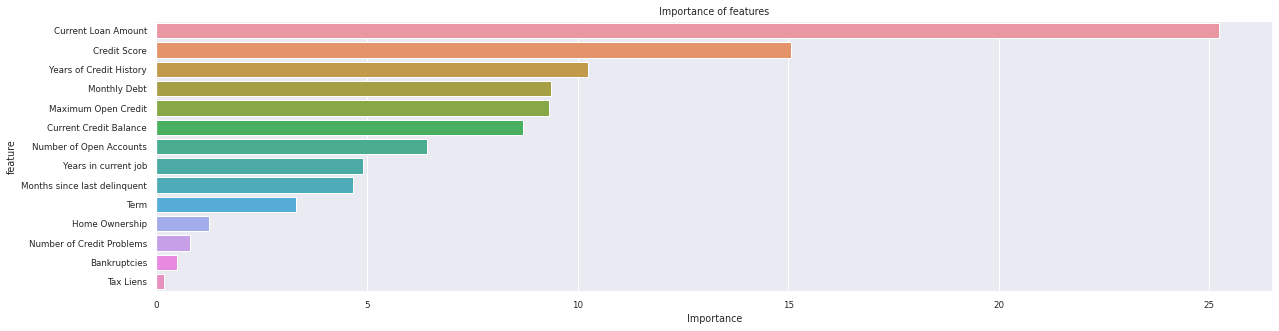

In [1775]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=11)

In [1776]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Years of Credit History',
 'Monthly Debt',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job',
 'Months since last delinquent',
 'Term',
 'Home Ownership']

In [1778]:
CAT_FEATURE_NAMES

['Years in current job', 'Term', 'Home Mortgage']

In [1779]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Term', 'Years in current job']

In [1790]:
%%time

frozen_params = {
     'class_weights': [1, disbalance], 
     'silent': True,
     'random_state': 21,
     'cat_features': NEW_CAT_FEATURE_NAMES,
     'eval_metric': 'F1',
     'early_stopping_rounds': 20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=7,
                                      reg_lambda=0.5)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.32      0.48      3771
           1       0.59      0.97      0.73      3771

    accuracy                           0.65      7542
   macro avg       0.75      0.65      0.61      7542
weighted avg       0.75      0.65      0.61      7542

TEST

              precision    recall  f1-score   support

           0       0.91      0.32      0.48      1616
           1       0.35      0.92      0.51       634

    accuracy                           0.49      2250
   macro avg       0.63      0.62      0.49      2250
weighted avg       0.76      0.49      0.49      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               524  1092
1                49   585
CPU times: user 2.6 s, sys: 390 ms, total: 2.99 s
Wall time: 1.7 s


In [1791]:
# MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

# with open(MODEL_FILE_PATH, 'wb') as file:
#     pickle.dump(final_model, file)

In [1792]:
NEW_CAT_FEATURE_NAMES

['Term', 'Years in current job']

In [1793]:
submit = pd.read_csv('/home/vika/GB/data_libr/Data_kursach/gb-credit-default/sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [1799]:
predictions = final_model.predict(test_df)
predictions

array([1, 1, 1, ..., 1, 0, 1])

In [1800]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [1801]:
submit.to_csv('/home/vika/GB/data_libr/Data_kursach/rf_submit.csv', index=False)